In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

class LivePlot:
    def __init__(self):
        self.data = collections.defaultdict(list)
        
    def add(self, label, *args):
        self.data[label] = args
        
    def __call__(self, figsize=(7,5), title=''):
        clear_output(wait=True)
        plt.figure(figsize=figsize)

        for label, data in self.data.items():
            plt.plot(*data, label=label)

        plt.title(title)
        plt.grid(True)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

In [2]:
import json
import numpy as np
import os
import sys
import torch
from time import strftime
from datasets import ActiveSineData
from pseudo_bo import PseudoBO

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 200

dataset = ActiveSineData()

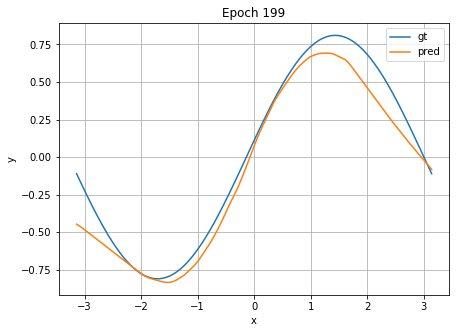

In [4]:
from models import MLP

mlp = MLP(x_dim=1, y_dim=1, h_dim=64).to(device)

opt = torch.optim.SGD(mlp.parameters(), lr=0.001)

for epoch in range(epochs):
    x, y = dataset.data
    x, y = x.to(device), y.to(device)
    yhat = mlp(x)
    loss = (y - yhat).pow(2).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    liveplt = LivePlot()
    liveplt.add('gt', x.detach().cpu().numpy(), y.detach().cpu().numpy())
    liveplt.add('pred', x.detach().cpu().numpy(), yhat.detach().cpu().numpy())
    liveplt(title='Epoch %d' % epoch)

In [5]:
pbo = PseudoBO(dataset, mlp, x_dim=1, y_dim=1, h_dim=64, lr=1e-3, bs=1, device=device, acq_scheme='min')

In [6]:
def sketch_net(epoch, pbo):
    x, y = dataset.data
    x = x.to(device)
    yhat = pbo.forward(x)
    liveplt = LivePlot()
    #liveplt.add('gt', x.detach().cpu().numpy(), y)
    liveplt.add('pred', x.detach().cpu().numpy(), yhat.detach().cpu().numpy())
    Dt = torch.cat(pbo.D[1:], 0).squeeze()
    R_Dt = dataset.inquiry(Dt)
    liveplt.add('D_t', Dt.detach().cpu().numpy(), R_Dt.detach().cpu().numpy(), 'r.')
    
    liveplt(title='Epoch %d' % epoch)

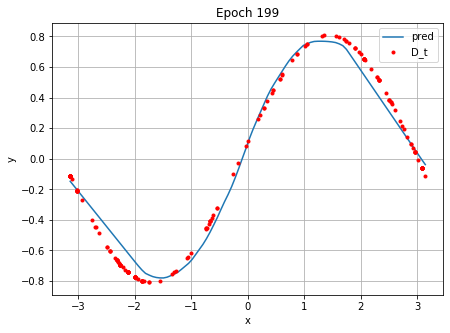

In [7]:
# main loop
for epoch in range(200):
    #pbo.acquisition(10, lr=0.001, debug=True)
    #print('-'*79)
    
    pbo.acquisition(10, lr=0.001, debug=False)
    sketch_net(epoch, pbo)

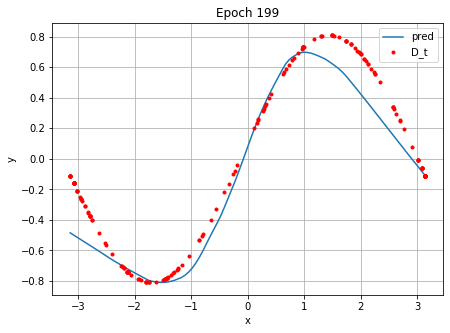

In [8]:
pbo_scratch = PseudoBO(dataset, None, x_dim=1, y_dim=1, h_dim=64, lr=5e-3, bs=1, device=device, acq_scheme='min')

# main loop
for epoch in range(200):
    pbo_scratch.acquisition(10, lr=0.001, debug=False)
    sketch_net(epoch, pbo_scratch)